In [1]:
import re
import glob
import pandas as pd
import nibabel as nb
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting

/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# importing rmaps

In [2]:
network_interest = "DMN"
connectivity_maps = glob.glob("rest/rmap_seeds/*sub*_"+network_interest+".nii.gz")
len(connectivity_maps)

112

# import csv file 

In [3]:
cimaq_diagnostic = 'cimaq_diagnostic_Nov_2019.csv'
cimaq_diagnostic = pd.read_csv(cimaq_diagnostic)

print(set(cimaq_diagnostic['V01 36448_diagnostic_clinique,36448_diagnostic_clinique'].values))
cimaq_diagnostic = cimaq_diagnostic[['V01 demographics,CandID','V01 36448_diagnostic_clinique,36448_diagnostic_clinique']]
cimaq_diagnostic.rename(columns = {"V01 demographics,CandID":"subID","V01 36448_diagnostic_clinique,36448_diagnostic_clinique":"diagnostic" },inplace=True)
cimaq_diagnostic.shape

{'démence_de_type_alzheimer-légère', 'trouble_cognitif_léger_tardif', 'cognitivement_sain_(cs)', 'troubles_subjectifs_de_cognition', 'trouble_cognitif_léger_précoce'}


(314, 2)

# create design matrix

In [4]:

cimaq_diagnostic["MCI"] = 0
cimaq_diagnostic["SCD"] = 0
cimaq_diagnostic["CN"] = 0

subjectID_set = set([sub.split("sub")[1].split("_")[0] for sub in connectivity_maps])
drop = []
for i,r in cimaq_diagnostic.iterrows():
    
    #
    if(r["diagnostic"] == "troubles_subjectifs_de_cognition" ):
        cimaq_diagnostic.loc[i,"SCD"] = 1

    if(r["diagnostic"] == "cognitivement_sain_(cs)"):
        cimaq_diagnostic.loc[i,"CN"] = 1          

    if("trouble_cognitif_léger" in r["diagnostic"] ):
        cimaq_diagnostic.loc[i,"MCI"] = 1


    cimaq_diagnostic.loc[i,"subID"] = str(r["subID"])
    

cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]
cimaq_diagnostic.head()

,subID,diagnostic,MCI,SCD,CN
3,658178,troubles_subjectifs_de_cognition,0,1,0
7,920577,troubles_subjectifs_de_cognition,0,1,0
10,199801,trouble_cognitif_léger_tardif,1,0,0
11,254530,troubles_subjectifs_de_cognition,0,1,0
16,748676,trouble_cognitif_léger_précoce,1,0,0


In [5]:
design_matrix = cimaq_diagnostic[["MCI","SCD","CN"]]
design_matrix.shape

(99, 3)

# perform  t-test

In [6]:
second_level_input = []
for i in connectivity_maps:
    sub = re.search("\d\d\d\d\d\d",i)
    subid = sub.group(0)
    if(subid in set(cimaq_diagnostic["subID"].values)):        
        second_level_input.append(i)


In [7]:
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
p_map = second_level_model.compute_contrast(second_level_contrast = [0,-1,1])

/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:83: UserWarning: Threshold given was 1e-06, but the data has no values below -4.130696773529053. 
  data.min()))



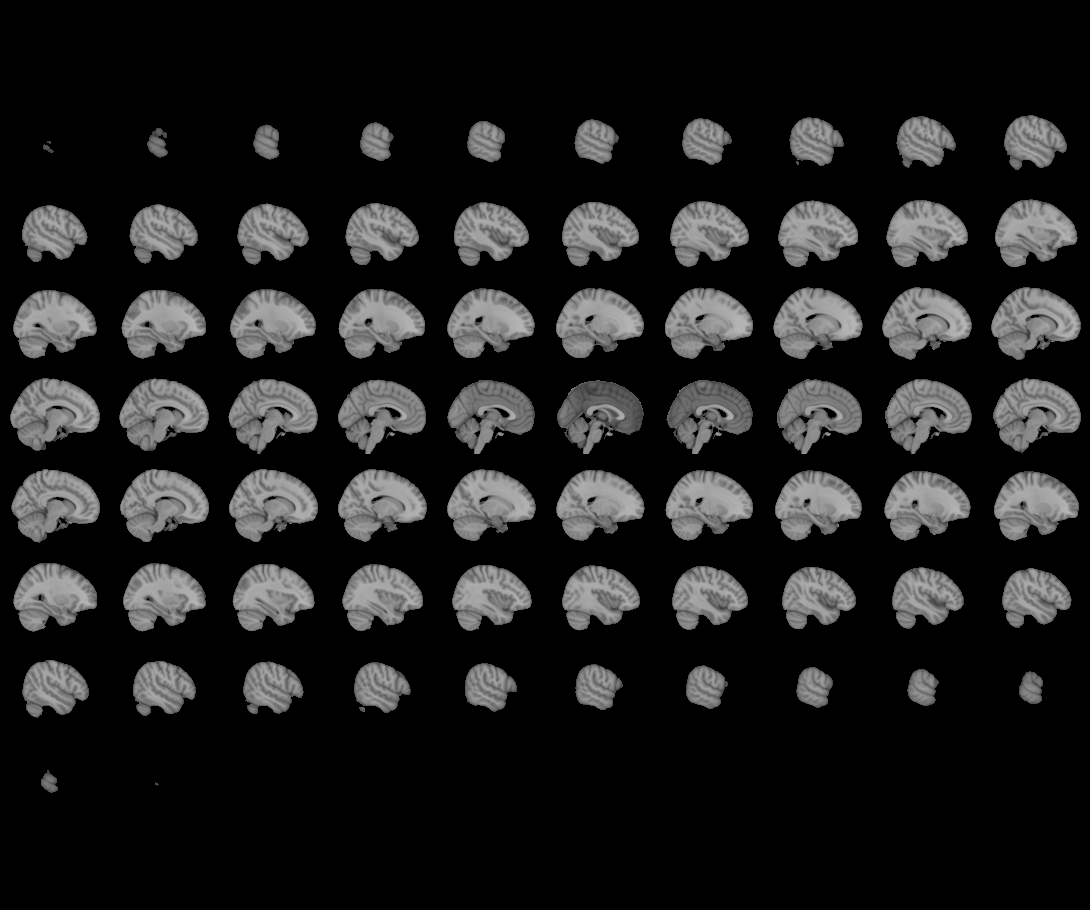
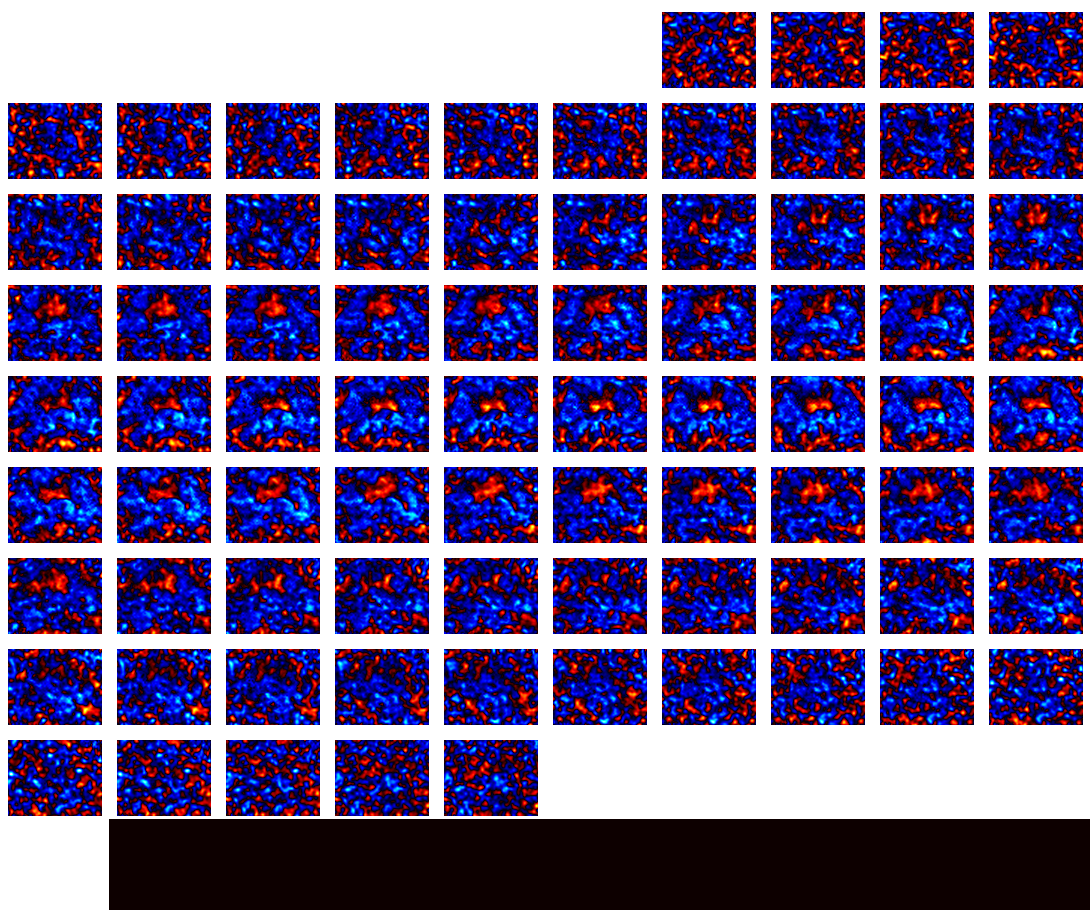

In [8]:
plotting.view_img(p_map)

/home/hanads/.local/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:71: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=1e-06 
  threshold))
/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:63: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))



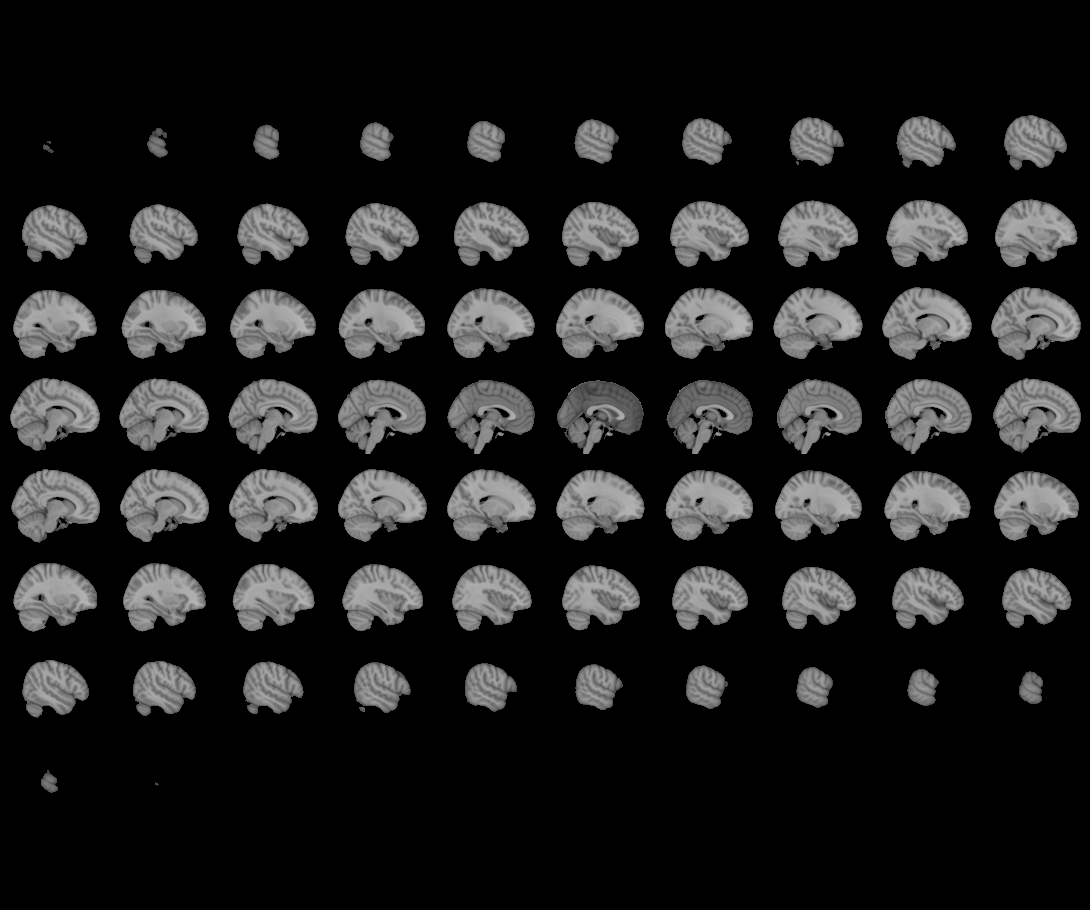
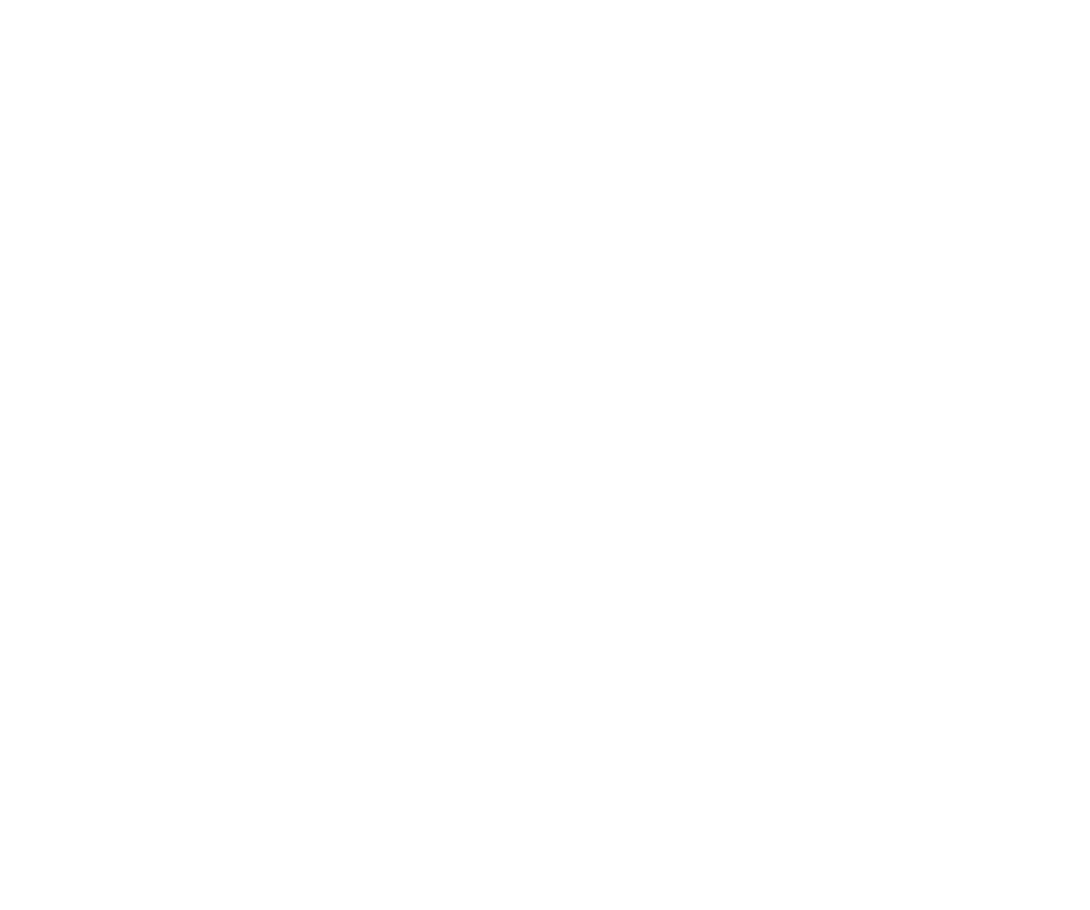

In [9]:
thresholded_map, threshold = map_threshold(p_map, alpha=0.5, height_control='fdr')
plotting.view_img(thresholded_map)

# F-test

In [10]:
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
p_map = second_level_model.compute_contrast(second_level_contrast = [1,1,1], second_level_stat_type = "F")

/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:83: UserWarning: Threshold given was 1e-06, but the data has no values below -3.9858713150024414. 
  data.min()))



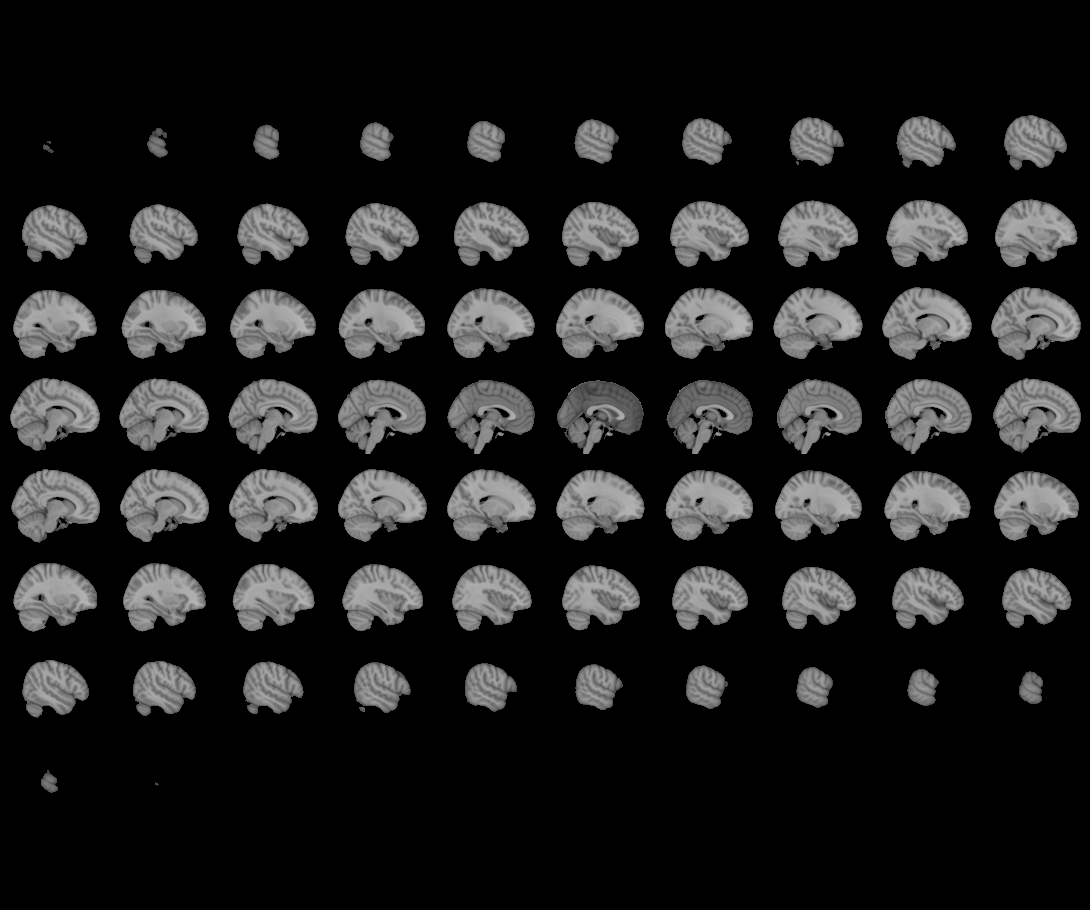
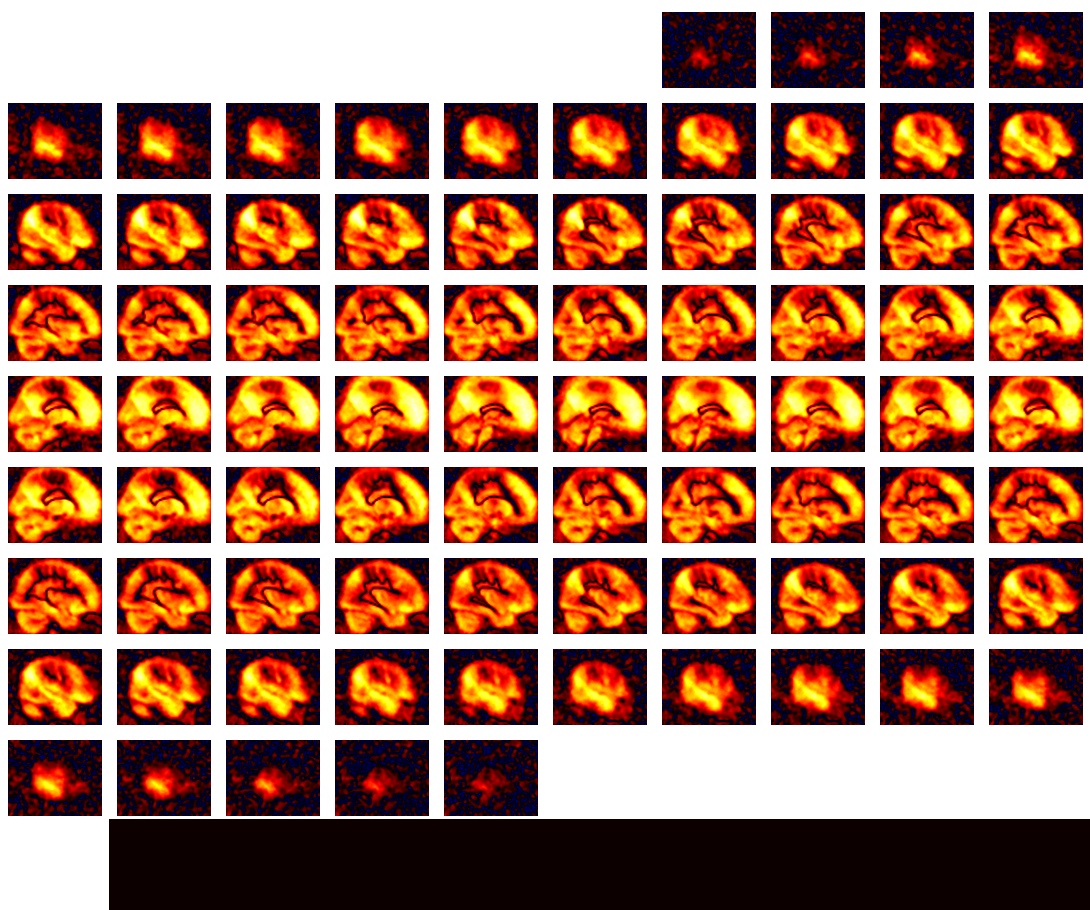

In [11]:
plotting.view_img(p_map)